In [1]:
# 환경설정 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./data/used_mobile_phone.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [3]:
# 개별 피처 탐색기 : date 피처 탐색

# create_date로 부터 '월'을 의미하는 month 정보를 피처로 추출
df['month'] = df['create_date'].apply(lambda x: x[:7])


# 월별 거래 횟수를 계산하여 출력
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

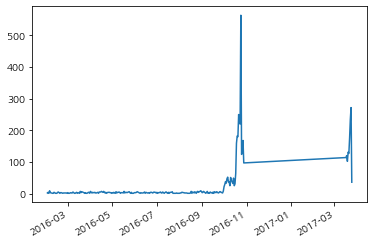

In [4]:
# 일별 거래 횟수를 계산하여 그래프 출력
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

<AxesSubplot:>

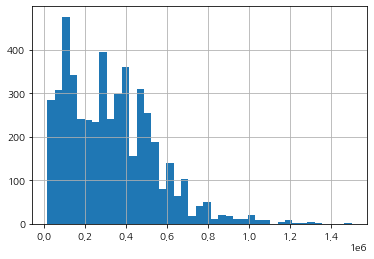

In [5]:
# 가격의 분포를 그래프
df['price'].hist(bins="auto")

<AxesSubplot:>

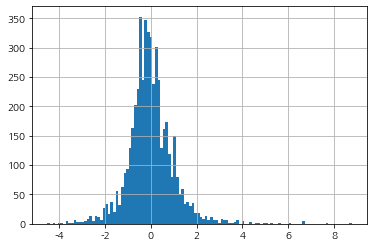

In [6]:
# 휴대폰 기종(phone_model)별 가격의 평균과 표준편차
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의  z-score를 계산 
# 가격이 기종별 평균에 비해 어느 정도로 높거나 낮은지 확인
df_price_model_z_score = (df['price'] - df_price_model_mean)/df_price_model_std
df_price_model_z_score.hist(bins="auto")

<AxesSubplot:xlabel='factory_price', ylabel='price'>

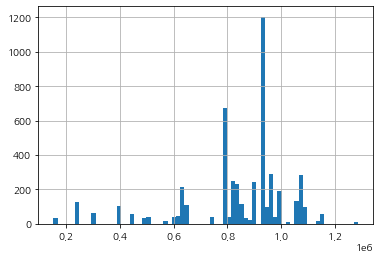

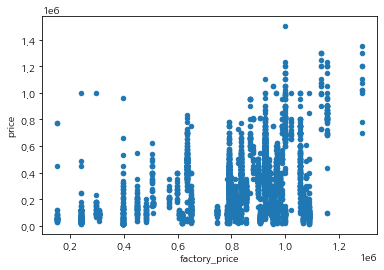

In [7]:
# factory_price 피처의 분포 탐색
df['factory_price'].hist(bins='auto')

# factory_price 와 price  피처를 산점도 그래프로 출력하여 상관 관계 확인 
df.plot.scatter(x='factory_price', y='price')

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


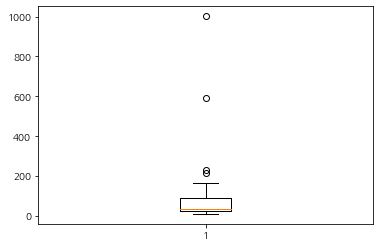

In [8]:
# 기종별 총 거래 데이터 개수를 집계
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그래프로 확인
plt.boxplot(model_counts)
plt.show()

In [9]:
# Random forest regressor를 이용한 가격 예측

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [10]:
# 데이터를 학습/데이트용 데이터로 분리

df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)


# 랜덤 포레스트 모델을 학습
forest = RandomForestRegressor(n_estimators=1000, criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델을 평가
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('R^2 train : %.3f, test: %.3f' %(r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

MSE train: 10622180657.000, test: 13860872156.024
R^2 train : 0.781, test: 0.683


[('factory_price', 0.40686028916517764),
 ('maker_apple', 0.297277664599571),
 ('phone_model_galaxy s3 3g 8gb', 0.022280533319372325),
 ('phone_model_iphone se 64gb', 0.021271594536621443),
 ('price_index', 0.02091687980397492),
 ('phone_model_galaxy s4 32gb', 0.017094464311713294),
 ('maker_samsung', 0.014819167863270687),
 ('month_2017-03', 0.014647749251115076),
 ('phone_model_galaxy s6 32gb', 0.012523186954083965),
 ('month_2016-05', 0.011062721147283718)]

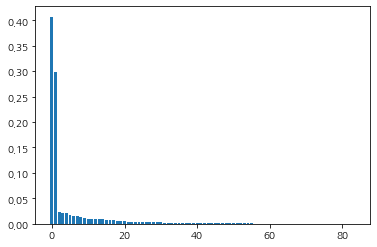

In [11]:
# 학습한 모델의 피처 중요도 시각화
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])


# 학습한 모델의 피처 중요도를 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [12]:
# month 피처 중, 영향력이 높은순으로 정렬
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.014647749251115076)
('month_2016-05', 0.011062721147283718)
('month_2016-09', 0.008476748610196549)
('month_2016-04', 0.007660440666632426)
('month_2016-10', 0.006199572097998019)
('month_2016-06', 0.0044943467107525815)
('month_2016-08', 0.003775294557880518)
('month_2016-07', 0.002706376669010776)
('month_2016-03', 0.0022900064739096236)
('month_2016-02', 0.0011511942984948292)


In [13]:
# 기존 피처 가공하기

# 데이터 다시 불러오기
df = pd.read_csv("./data/used_mobile_phone.csv")

from datetime import datetime
import time

# create_date 피처를 수치적으로 계한하기 위해  unixtime으로 변환하는 함수를 정의
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

# create_date 피처를 ‘현재와 얼마나 가까운 데이터인 지’ 판단하기 위한 점수를 생성합니다. 먼저 unixtime으로 데이터를 변환합니다.
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))
print(df['create_unixtime'][:10])

0    1.489849e+09
1    1.477408e+09
2    1.477321e+09
3    1.490195e+09
4    1.460300e+09
5    1.490108e+09
6    1.490195e+09
7    1.475766e+09
8    1.490368e+09
9    1.458659e+09
Name: create_unixtime, dtype: float64


In [14]:
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
                          (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489849e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477408e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477321e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490195e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460300e+09,0.165468


In [15]:
# phone_model 피처 분리
# phone_model 피처에서 저장 용량(phone_model_storage) 피처를 추출합니다.
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

# phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출합니다.
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


{'whiskers': [<matplotlib.lines.Line2D at 0x156b44cd730>,
 'caps': [<matplotlib.lines.Line2D at 0x156b44cddf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x156b44cd430>,
 'medians': [<matplotlib.lines.Line2D at 0x156b44d74f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x156b44d7850>,
 'means': []}

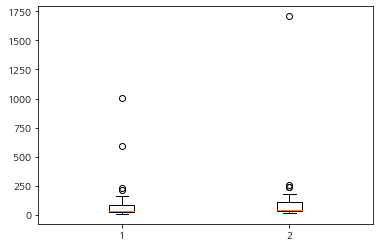

In [16]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계합니다.
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처간의 기종별 거래 데이터 개수를 비교합니다.
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

In [17]:
# phone_model 관련 딕셔너리 생성

# 기종명 + 용량으로 출고가를 찾기 위한 딕셔너리를 생성합니다.
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['phone_model_detail'], row['phone_model_storage'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], "...")

{('iphone 6', '64gb'): 924000, ('galaxy  ...


-1.3966616903783426
1.666982156397844


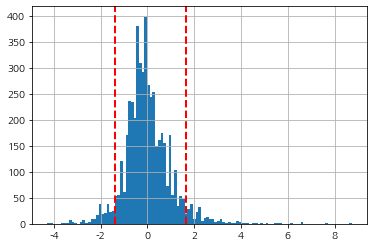

In [18]:
# 감정 분석으로 물품의 상태 분류하기

# 감성분류의 정답 데이터셋 생성

# 거래 가격(price)의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

# 거래 가격의 z-score(price_by_group)의 분포를 그래프로 출력합니다
ax = df['price_by_group'].hist(bins="auto")

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound 라고 지정합니다.
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가합니다.
ax.axvline(x = lower_bound, color = 'r', linestyle = 'dashed', linewidth = 2)
ax.axvline(x = upper_bound, color = 'r', linestyle = 'dashed', linewidth = 2)

# lower_bound를, upper_bound 출력합니다.
print(lower_bound)
print(upper_bound)

In [19]:
# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류하는 함수를 정의합니다.
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"

# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류합니다.
df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], 
                                                         row['price_upper']), axis=1)
df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


### 텍스트 전처리

In [20]:
import pickle
import re

# 중고나라 불용어 사전을 불러옴
with open('./data/used_mobile_phone_stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)
    
# 불용어 사전에 등록된 단어 10개를 출력
print(stopwords[:10])

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']


In [21]:
from konlpy.tag import Okt

# ‘+’를 제외한 특수문자를 제거하고, 숫자형태의 문자를 제거합니다.
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수입니다.
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

# 위 함수들을 적용한 형태소 추출을 테스트합니다.
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


In [22]:
# 빈출 형태소 2,500개 선정하기
from collections import Counter

# get_pos() 함수를 모든 텍스트에 적용하여 형태소 말뭉치를 추출
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), [])

# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

In [23]:
# TF - IDF 벡터 생성
df['price_level'].value_counts()

1    4296
0     334
2     321
Name: price_level, dtype: int64

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
# 빈출 형태서를 제외한 모든 형태소를 제거하는 함수를 정의
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]
    
# 1:3:1 비율로 갠덤 샘플링을 수행
negative_random = df[df['price_level'] == '0'].sample(321, random_state = 30)
neutral_random = df[df['price_level'] == '1'].sample(321*3, random_state = 30)
positive_random = df[df['price_level'] == '2'].sample(321, random_state = 30)

# 샘플링 완료된 데이터셋을 정의
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF를 수행하여 피처를 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류를 위한 학습 데이터셋 정의
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)
print(x_train.shape)
print(x_test.shape)

(1284, 2476)
(321, 2476)


In [26]:
# 상품 상태 분류
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#비선형 SVM 분류 모델을 학습하고 평가
svm = SVC(kernel = 'rbf', C = 10.0, random_state = 0, gamma = 0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy : %.2f' % accuracy_score(y_test, y_pred_ksvc))

# Confusion Matrix를 출력
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred_ksvc)
print(confmat)

Accuracy : 0.77
[[ 30  28   4]
 [ 10 181  10]
 [  2  21  35]]


In [27]:
# [Random forest regressor 재학습]

X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

# 랜덤 포레스트 모델 학습을 위한 데이터 준비
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage', 'phone_model_detail', 'product_status']]
df = pd.get_dummies(df, columns = ['maker', 'phone_model_storage', 'phone_model_detail', 'product_status'])

# 학습 / 테스트 데이터 분리
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

MSE train : 4765757433.472, test : 11083619056.727
R^2 train : 0.902, test : 0.747


[('factory_price', 0.2550361955065921),
 ('maker_apple', 0.2532633767237259),
 ('create_time_score', 0.11711353975778226),
 ('phone_model_storage_16gb', 0.06150833392947854),
 ('product_status_2', 0.04729489113426566),
 ('phone_model_detail_galaxy s7 edge', 0.02821827536510415),
 ('phone_model_storage_64gb', 0.02480885205745971),
 ('phone_model_detail_galaxy note5', 0.02410436067942166),
 ('phone_model_detail_galaxy s7', 0.021994659368936197),
 ('product_status_0', 0.021622394919417455)]

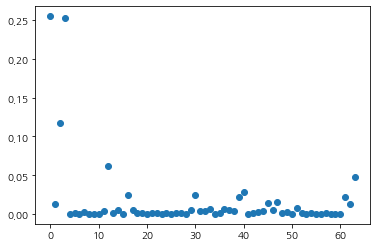

In [29]:
# 랜덤 포레스트 모델을 학습하고 평가
forest = RandomForestRegressor(n_estimators = 1000, criterion = 'mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train : %.3f, test : %.3f' %(mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('R^2 train : %.3f, test : %.3f' %(r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

# 피처 중요도 plot 출력
importances = forest.feature_importances_
plt.plot(importances, 'o')

# 피처 중요도 print 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key = lambda tup: tup[1], reverse = True)[:10]

In [30]:
# feature-index 관련 딕셔너리 생성

# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'price_index': 1, ' ...


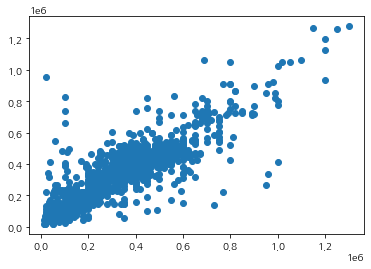

In [31]:
# 예측 결과 scatter plot

# 테스트 데이터의 y값과 예측된 y값을 scatter plot을 활용하여 상관관계를 확인
plt.scatter(y_test.values, y_test_pred)

In [33]:
# 최적의 모델 파라미터 찾기
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의
random_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'bootstrap' : bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1)

# RandomizedSearchCV 모델을 학습
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [34]:
# 최적 파라미터 출력

# 앞서 선정한 파마미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합을 출력
optimal_forest.best_params_

{'n_estimators': 2000,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

MSE train : 8808355084.787, test : 7645656926.760
R^2 train : 0.818, test : 0.825


[('factory_price', 0.2965625127636589),
 ('maker_apple', 0.2756146345724776),
 ('phone_model_storage_16gb', 0.07214708691062482),
 ('create_time_score', 0.0658135264074267),
 ('product_status_2', 0.06265874991988148),
 ('phone_model_detail_galaxy s7 edge', 0.027077101027418955),
 ('phone_model_detail_iphone 6', 0.025027806036671152),
 ('product_status_0', 0.02479775887832165),
 ('phone_model_detail_galaxy s4', 0.020530253032971974),
 ('product_status_1', 0.013430117158792445)]

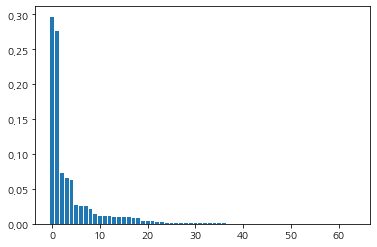

In [36]:
# 최적 모델 학습 결과

# 최적의 파라미터를 적용한 모델로 중고폰의 가격을 예측/평가
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train : %.3f, test : %.3f' %(mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('R^2 train : %.3f, test : %.3f' %(r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

# 가격 예측 모델의 피처 중요도 plot을 출력
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 가격 예측 모델의 피처 중요도를 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key = lambda tup: tup[1], reverse = True)[:10]

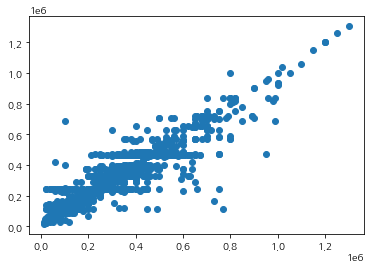

In [37]:
# 예측 결과 scatter plot

# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계 확인
plt.scatter(y_test.values, y_test_pred)

## 재사용을 위한 파일 저장

In [39]:
# https://github.com/yoonkt200/python-data-analysis/blob/master/chapter5/01-used-phone-price-prediction.ipynb
# https://github.com/yoonkt200/python-data-analysis 에서 확인 할것
# 폴더 경로등 수정 필요....